In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch

import scanpy as sc
import anndata

import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse

In [5]:
torch.set_num_threads(40)

In [4]:
input_path = "../../appeal/snare_p0/"
output_path = "../../appeal/snare_p0/scMVP_output/"
n_epochs_all = None
show_plot = True
test_mode = False

snare_p0_dataset = {
                "gene_names": 'snare_p0_scale_gene.txt',
                "gene_expression": 'snare_p0_rna_normalize_count.mtx',
                "gene_barcodes": 'snare_p0_cell_barcode.txt',
                "atac_names": '../bench/snare_p0_peak50000.txt',
                "atac_expression": '../bench/snare_p0_atac_normalize_count50000.mtx',
                "atac_barcodes": 'snare_p0_cell_barcode.txt'
                }
#cell_embeddings = pd.read_csv(input_path+'snare_p0_wnn_output.txt', sep="\t",index_col=None).iloc[:,[0,11]]
dataset = LoadData(dataset=snare_p0_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)

[2021-07-18 21:57:15,372] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2021-07-18 21:57:41,054] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2021-07-18 21:57:41,152] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-07-18 21:57:41,153] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-07-18 21:57:44,574] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-07-18 21:57:44,611] INFO - scMVP.dataset.dataset | Downsampled from 5081 to 5081 cells


In [6]:
##### 
lr = 5e-3
use_batches = False
use_cuda = True
n_centroids = 15
n_alfa = 1.0
n_centroids=8

# joint RNA and ATAC embedding
multi_vae = Multi_VAE_Attention(dataset.nb_genes, len(dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

# if os.path.exists("{}/multi_vae_trainer.pkl".format(output_path)):
#     trainer.model.load_state_dict(torch.load("{}/multi_vae_trainer.pkl".format(output_path)))
# else:
trainer.train(n_epochs=15, lr=lr)
torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer_no_pretrain.pkl' % output_path)

trainer.model.eval()

full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

training:   0%|          | 0/15 [00:00<?, ?it/s]logpzc:-103.30850219726562, logqcx:-2.0794413089752197
kld_qz_pz = 62.180279,kld_qz_rna = 6.011475,kld_qz_atac = 5.246592,kl_divergence = 62.721184,reconst_loss_rna = 1541.988770,        reconst_loss_atac = 1014.334473, mu=0.000000, sigma=1.000000
reconst_loss = 2606.691406,kl_divergence_local = 62.721184,kl_weight = 1.000000,loss = 2669.412598
tensor(2669.4126, grad_fn=<DivBackward0>)
logpzc:-41.60340118408203, logqcx:-2.0794413089752197
kld_qz_pz = 6.918556,kld_qz_rna = 6.467352,kld_qz_atac = 6.237254,kl_divergence = 7.586539,reconst_loss_rna = 1485.013672,        reconst_loss_atac = 971.174500, mu=-0.000397, sigma=1.004778
reconst_loss = 2506.556396,kl_divergence_local = 7.586539,kl_weight = 1.000000,loss = 2514.142822
tensor(2514.1428, grad_fn=<DivBackward0>)
logpzc:-36.521400451660156, logqcx:-2.0794408321380615
kld_qz_pz = 3.965042,kld_qz_rna = 8.266329,kld_qz_atac = 8.596493,kl_divergence = 4.760421,reconst_loss_rna = 1300.880005, 

logpzc:-39.08724594116211, logqcx:-2.0794403553009033
kld_qz_pz = 8.700004,kld_qz_rna = 28.651613,kld_qz_atac = 25.834919,kl_divergence = 10.365018,reconst_loss_rna = 1058.727783,        reconst_loss_atac = 923.384766, mu=-0.008477, sigma=1.036485
reconst_loss = 2032.480713,kl_divergence_local = 10.365018,kl_weight = 1.000000,loss = 2042.845581
tensor(2042.8456, grad_fn=<DivBackward0>)
logpzc:-39.01390075683594, logqcx:-2.079439401626587
kld_qz_pz = 8.542267,kld_qz_rna = 28.205263,kld_qz_atac = 25.277376,kl_divergence = 10.166245,reconst_loss_rna = 1060.876709,        reconst_loss_atac = 923.468872, mu=-0.008868, sigma=1.037575
reconst_loss = 2034.713623,kl_divergence_local = 10.166245,kl_weight = 1.000000,loss = 2044.879761
tensor(2044.8798, grad_fn=<DivBackward0>)
logpzc:-37.17496109008789, logqcx:-2.0793604850769043
kld_qz_pz = 6.620194,kld_qz_rna = 25.957413,kld_qz_atac = 22.761625,kl_divergence = 8.180163,reconst_loss_rna = 1027.890991,        reconst_loss_atac = 833.666138, mu=-0

logpzc:-31.783039093017578, logqcx:-2.077554702758789
kld_qz_pz = 2.347962,kld_qz_rna = 26.767647,kld_qz_atac = 26.218906,kl_divergence = 3.770309,reconst_loss_rna = 971.283386,        reconst_loss_atac = 730.825012, mu=-0.014882, sigma=1.059087
reconst_loss = 1752.431885,kl_divergence_local = 3.770309,kl_weight = 1.000000,loss = 1756.202393
tensor(1756.2024, grad_fn=<DivBackward0>)
logpzc:-32.31768035888672, logqcx:-2.078314781188965
kld_qz_pz = 2.852149,kld_qz_rna = 27.613527,kld_qz_atac = 26.793310,kl_divergence = 4.433796,reconst_loss_rna = 1038.247803,        reconst_loss_atac = 806.380005, mu=-0.015072, sigma=1.059749
reconst_loss = 1894.973755,kl_divergence_local = 4.433796,kl_weight = 1.000000,loss = 1899.407593
tensor(1899.4076, grad_fn=<DivBackward0>)
logpzc:-32.31064987182617, logqcx:-2.0780603885650635
kld_qz_pz = 2.866862,kld_qz_rna = 28.657503,kld_qz_atac = 27.543947,kl_divergence = 4.550902,reconst_loss_rna = 991.700378,        reconst_loss_atac = 836.222473, mu=-0.01528

logpzc:-31.742645263671875, logqcx:-2.0781195163726807
kld_qz_pz = 2.457500,kld_qz_rna = 32.463142,kld_qz_atac = 30.240305,kl_divergence = 4.151049,reconst_loss_rna = 1000.650635,        reconst_loss_atac = 799.320190, mu=-0.019210, sigma=1.071953
reconst_loss = 1850.308228,kl_divergence_local = 4.151049,kl_weight = 1.000000,loss = 1854.459473
tensor(1854.4595, grad_fn=<DivBackward0>)
logpzc:-31.762338638305664, logqcx:-2.0780622959136963
kld_qz_pz = 2.492500,kld_qz_rna = 32.793915,kld_qz_atac = 30.697550,kl_divergence = 4.166612,reconst_loss_rna = 1027.221802,        reconst_loss_atac = 834.062439, mu=-0.019346, sigma=1.072504
reconst_loss = 1911.621460,kl_divergence_local = 4.166612,kl_weight = 1.000000,loss = 1915.788086
tensor(1915.7881, grad_fn=<DivBackward0>)
logpzc:-31.50518035888672, logqcx:-2.0776474475860596
kld_qz_pz = 2.271853,kld_qz_rna = 33.882599,kld_qz_atac = 31.426283,kl_divergence = 4.025038,reconst_loss_rna = 1000.235779,        reconst_loss_atac = 812.897339, mu=-0.

kld_qz_pz = 1.520342,kld_qz_rna = 38.305244,kld_qz_atac = 35.564278,kl_divergence = 3.525185,reconst_loss_rna = 1029.242065,        reconst_loss_atac = 805.626282, mu=-0.022594, sigma=1.080625
reconst_loss = 1884.846436,kl_divergence_local = 3.525185,kl_weight = 1.000000,loss = 1888.371704
tensor(1888.3717, grad_fn=<DivBackward0>)
logpzc:-30.999380111694336, logqcx:-2.067389726638794
kld_qz_pz = 1.860446,kld_qz_rna = 37.927444,kld_qz_atac = 35.252316,kl_divergence = 3.930387,reconst_loss_rna = 1064.526123,        reconst_loss_atac = 829.686035, mu=-0.022770, sigma=1.080876
reconst_loss = 1944.245850,kl_divergence_local = 3.930387,kl_weight = 1.000000,loss = 1948.176147
tensor(1948.1761, grad_fn=<DivBackward0>)
logpzc:-30.94744873046875, logqcx:-2.0653035640716553
kld_qz_pz = 1.804439,kld_qz_rna = 38.454159,kld_qz_atac = 34.914879,kl_divergence = 3.790614,reconst_loss_rna = 1005.891052,        reconst_loss_atac = 787.380310, mu=-0.022949, sigma=1.081076
reconst_loss = 1843.242920,kl_div

logpzc:-29.563596725463867, logqcx:-1.0832750797271729
kld_qz_pz = 1.052573,kld_qz_rna = 44.093754,kld_qz_atac = 40.745171,kl_divergence = 3.071316,reconst_loss_rna = 968.423523,        reconst_loss_atac = 827.996887, mu=-0.024653, sigma=1.102141
reconst_loss = 1811.451538,kl_divergence_local = 3.071316,kl_weight = 1.000000,loss = 1814.522949
tensor(1814.5229, grad_fn=<DivBackward0>)
logpzc:-29.40795135498047, logqcx:-0.8974032402038574
kld_qz_pz = 1.028123,kld_qz_rna = 45.020779,kld_qz_atac = 41.628849,kl_divergence = 2.953701,reconst_loss_rna = 971.121948,        reconst_loss_atac = 752.292603, mu=-0.024387, sigma=1.106408
reconst_loss = 1731.508301,kl_divergence_local = 2.953701,kl_weight = 1.000000,loss = 1734.461914
tensor(1734.4619, grad_fn=<DivBackward0>)
logpzc:-29.509241104125977, logqcx:-0.7813084125518799
kld_qz_pz = 1.206445,kld_qz_rna = 45.584148,kld_qz_atac = 42.991688,kl_divergence = 3.378974,reconst_loss_rna = 999.379456,        reconst_loss_atac = 755.391968, mu=-0.024

logpzc:-29.61258888244629, logqcx:-0.056969691067934036
kld_qz_pz = 1.661708,kld_qz_rna = 58.668480,kld_qz_atac = 55.979740,kl_divergence = 4.789222,reconst_loss_rna = 951.989258,        reconst_loss_atac = 778.124084, mu=-0.019083, sigma=1.168506
reconst_loss = 1708.362793,kl_divergence_local = 4.789222,kl_weight = 1.000000,loss = 1713.151978
tensor(1713.1520, grad_fn=<DivBackward0>)
logpzc:-29.585100173950195, logqcx:-0.05255987122654915
kld_qz_pz = 1.631615,kld_qz_rna = 58.363987,kld_qz_atac = 55.911900,kl_divergence = 4.473122,reconst_loss_rna = 987.690613,        reconst_loss_atac = 735.456055, mu=-0.018980, sigma=1.169583
reconst_loss = 1701.256958,kl_divergence_local = 4.473122,kl_weight = 1.000000,loss = 1705.730225
tensor(1705.7302, grad_fn=<DivBackward0>)
logpzc:-29.598127365112305, logqcx:-0.04708719998598099
kld_qz_pz = 1.642289,kld_qz_rna = 58.760601,kld_qz_atac = 56.034184,kl_divergence = 4.321500,reconst_loss_rna = 1000.000732,        reconst_loss_atac = 789.471008, mu=-

logpzc:-30.094955444335938, logqcx:-0.031207969412207603
kld_qz_pz = 2.088181,kld_qz_rna = 58.254181,kld_qz_atac = 55.186642,kl_divergence = 5.181067,reconst_loss_rna = 977.248474,        reconst_loss_atac = 756.368164, mu=-0.018210, sigma=1.178528
reconst_loss = 1711.052002,kl_divergence_local = 5.181067,kl_weight = 1.000000,loss = 1716.233276
tensor(1716.2333, grad_fn=<DivBackward0>)
logpzc:-30.033836364746094, logqcx:-0.028430216014385223
kld_qz_pz = 2.026543,kld_qz_rna = 57.732822,kld_qz_atac = 54.957489,kl_divergence = 4.814213,reconst_loss_rna = 1043.943359,        reconst_loss_atac = 830.170349, mu=-0.018216, sigma=1.178664
reconst_loss = 1851.448853,kl_divergence_local = 4.814213,kl_weight = 1.000000,loss = 1856.263184
tensor(1856.2632, grad_fn=<DivBackward0>)
logpzc:-30.16193389892578, logqcx:-0.03117019310593605
kld_qz_pz = 2.151000,kld_qz_rna = 58.294662,kld_qz_atac = 54.971119,kl_divergence = 5.012519,reconst_loss_rna = 930.681152,        reconst_loss_atac = 720.402344, mu=

kld_qz_pz = 2.253524,kld_qz_rna = 58.228073,kld_qz_atac = 54.450588,kl_divergence = 5.026903,reconst_loss_rna = 950.940918,        reconst_loss_atac = 796.777954, mu=-0.018492, sigma=1.179938
reconst_loss = 1725.103027,kl_divergence_local = 5.026903,kl_weight = 1.000000,loss = 1730.129883
tensor(1730.1299, grad_fn=<DivBackward0>)
logpzc:-30.224393844604492, logqcx:-0.026487423107028008
kld_qz_pz = 2.181278,kld_qz_rna = 58.265144,kld_qz_atac = 54.421585,kl_divergence = 4.750436,reconst_loss_rna = 964.701233,        reconst_loss_atac = 770.334778, mu=-0.018492, sigma=1.179966
reconst_loss = 1712.314941,kl_divergence_local = 4.750436,kl_weight = 1.000000,loss = 1717.065430
tensor(1717.0654, grad_fn=<DivBackward0>)
logpzc:-30.168563842773438, logqcx:-0.024786463007330894
kld_qz_pz = 2.124985,kld_qz_rna = 58.027466,kld_qz_atac = 54.558697,kl_divergence = 4.763571,reconst_loss_rna = 1006.669434,        reconst_loss_atac = 802.487061, mu=-0.018491, sigma=1.179994
reconst_loss = 1786.378418,kl

logpzc:-30.386337280273438, logqcx:-0.02711332030594349
kld_qz_pz = 2.312381,kld_qz_rna = 58.221188,kld_qz_atac = 54.280628,kl_divergence = 5.158617,reconst_loss_rna = 993.036255,        reconst_loss_atac = 754.327637, mu=-0.018553, sigma=1.180581
reconst_loss = 1724.657349,kl_divergence_local = 5.158617,kl_weight = 1.000000,loss = 1729.816162
tensor(1729.8162, grad_fn=<DivBackward0>)
logpzc:-30.376230239868164, logqcx:-0.027673378586769104
kld_qz_pz = 2.300823,kld_qz_rna = 57.180756,kld_qz_atac = 54.433510,kl_divergence = 5.155716,reconst_loss_rna = 986.899658,        reconst_loss_atac = 760.671082, mu=-0.018549, sigma=1.180611
reconst_loss = 1724.887695,kl_divergence_local = 5.155716,kl_weight = 1.000000,loss = 1730.043213
tensor(1730.0432, grad_fn=<DivBackward0>)
logpzc:-30.37917709350586, logqcx:-0.02789248898625374
kld_qz_pz = 2.302473,kld_qz_rna = 57.059937,kld_qz_atac = 54.373314,kl_divergence = 5.155565,reconst_loss_rna = 983.848694,        reconst_loss_atac = 778.488831, mu=-0

training:  20%|██        | 3/15 [05:43<23:03, 115.27s/it]logpzc:-30.32758331298828, logqcx:-0.025926757603883743
kld_qz_pz = 2.227899,kld_qz_rna = 60.012482,kld_qz_atac = 56.335732,kl_divergence = 4.971503,reconst_loss_rna = 948.240234,        reconst_loss_atac = 738.216553, mu=-0.018646, sigma=1.181137
reconst_loss = 1663.726196,kl_divergence_local = 4.971503,kl_weight = 1.000000,loss = 1668.697754
tensor(1668.6978, grad_fn=<DivBackward0>)
logpzc:-30.27971076965332, logqcx:-0.024045057594776154
kld_qz_pz = 2.179339,kld_qz_rna = 59.843914,kld_qz_atac = 56.578957,kl_divergence = 4.792524,reconst_loss_rna = 985.995667,        reconst_loss_atac = 833.171753, mu=-0.018642, sigma=1.181164
reconst_loss = 1796.366821,kl_divergence_local = 4.792524,kl_weight = 1.000000,loss = 1801.159546
tensor(1801.1595, grad_fn=<DivBackward0>)
logpzc:-30.30653190612793, logqcx:-0.02440282702445984
kld_qz_pz = 2.205039,kld_qz_rna = 60.478794,kld_qz_atac = 56.908226,kl_divergence = 4.955667,reconst_loss_rna = 

logpzc:-30.297311782836914, logqcx:-0.024723147973418236
kld_qz_pz = 2.174069,kld_qz_rna = 61.835209,kld_qz_atac = 58.409424,kl_divergence = 5.163462,reconst_loss_rna = 976.469543,        reconst_loss_atac = 793.672607, mu=-0.018662, sigma=1.181707
reconst_loss = 1747.366699,kl_divergence_local = 5.163462,kl_weight = 1.000000,loss = 1752.530151
tensor(1752.5302, grad_fn=<DivBackward0>)
logpzc:-30.28153419494629, logqcx:-0.02495538629591465
kld_qz_pz = 2.157007,kld_qz_rna = 62.023094,kld_qz_atac = 58.477478,kl_divergence = 5.044938,reconst_loss_rna = 968.549255,        reconst_loss_atac = 803.488892, mu=-0.018673, sigma=1.181731
reconst_loss = 1749.275146,kl_divergence_local = 5.044938,kl_weight = 1.000000,loss = 1754.320068
tensor(1754.3201, grad_fn=<DivBackward0>)
logpzc:-30.277040481567383, logqcx:-0.024199122563004494
kld_qz_pz = 2.151401,kld_qz_rna = 62.310833,kld_qz_atac = 58.671104,kl_divergence = 5.064749,reconst_loss_rna = 967.762573,        reconst_loss_atac = 776.417114, mu=-

kld_qz_pz = 2.080558,kld_qz_rna = 63.328442,kld_qz_atac = 59.279003,kl_divergence = 4.993473,reconst_loss_rna = 997.897461,        reconst_loss_atac = 759.944397, mu=-0.018787, sigma=1.182142
reconst_loss = 1734.966187,kl_divergence_local = 4.993473,kl_weight = 1.000000,loss = 1739.959595
tensor(1739.9596, grad_fn=<DivBackward0>)
logpzc:-30.31618881225586, logqcx:-0.024560194462537766
kld_qz_pz = 2.164505,kld_qz_rna = 63.024132,kld_qz_atac = 59.250034,kl_divergence = 5.299401,reconst_loss_rna = 915.518188,        reconst_loss_atac = 861.541565, mu=-0.018778, sigma=1.182166
reconst_loss = 1754.278442,kl_divergence_local = 5.299401,kl_weight = 1.000000,loss = 1759.577881
tensor(1759.5779, grad_fn=<DivBackward0>)
logpzc:-30.314104080200195, logqcx:-0.026328861713409424
kld_qz_pz = 2.160874,kld_qz_rna = 63.390072,kld_qz_atac = 59.145256,kl_divergence = 5.367151,reconst_loss_rna = 937.159607,        reconst_loss_atac = 746.429993, mu=-0.018773, sigma=1.182190
reconst_loss = 1660.882690,kl_d

logpzc:-30.22161293029785, logqcx:-0.021448060870170593
kld_qz_pz = 2.044291,kld_qz_rna = 64.144737,kld_qz_atac = 60.139118,kl_divergence = 5.063254,reconst_loss_rna = 962.251526,        reconst_loss_atac = 778.441895, mu=-0.018920, sigma=1.182637
reconst_loss = 1717.808594,kl_divergence_local = 5.063254,kl_weight = 1.000000,loss = 1722.871704
tensor(1722.8717, grad_fn=<DivBackward0>)
logpzc:-30.226314544677734, logqcx:-0.02257070317864418
kld_qz_pz = 2.047556,kld_qz_rna = 64.371857,kld_qz_atac = 60.355595,kl_divergence = 5.117158,reconst_loss_rna = 956.216675,        reconst_loss_atac = 676.595886, mu=-0.018925, sigma=1.182663
reconst_loss = 1609.969116,kl_divergence_local = 5.117158,kl_weight = 1.000000,loss = 1615.086182
tensor(1615.0862, grad_fn=<DivBackward0>)
logpzc:-30.280649185180664, logqcx:-0.022849541157484055
kld_qz_pz = 2.100492,kld_qz_rna = 65.119850,kld_qz_atac = 60.708176,kl_divergence = 5.219185,reconst_loss_rna = 974.542847,        reconst_loss_atac = 864.209656, mu=-

logpzc:-30.197673797607422, logqcx:-0.02203976735472679
kld_qz_pz = 1.994481,kld_qz_rna = 64.709648,kld_qz_atac = 61.526619,kl_divergence = 5.085065,reconst_loss_rna = 980.246704,        reconst_loss_atac = 829.887085, mu=-0.018824, sigma=1.183209
reconst_loss = 1787.269775,kl_divergence_local = 5.085065,kl_weight = 1.000000,loss = 1792.354614
tensor(1792.3546, grad_fn=<DivBackward0>)
logpzc:-30.219127655029297, logqcx:-0.023429321125149727
kld_qz_pz = 2.014478,kld_qz_rna = 64.683907,kld_qz_atac = 61.534233,kl_divergence = 5.021709,reconst_loss_rna = 973.467529,        reconst_loss_atac = 830.939270, mu=-0.018818, sigma=1.183232
reconst_loss = 1781.594849,kl_divergence_local = 5.021709,kl_weight = 1.000000,loss = 1786.616699
tensor(1786.6167, grad_fn=<DivBackward0>)
logpzc:-30.19761848449707, logqcx:-0.02260393276810646
kld_qz_pz = 1.991965,kld_qz_rna = 65.394165,kld_qz_atac = 61.587177,kl_divergence = 5.024204,reconst_loss_rna = 934.661133,        reconst_loss_atac = 771.919922, mu=-0

kld_qz_pz = 2.003799,kld_qz_rna = 66.402779,kld_qz_atac = 62.552677,kl_divergence = 5.195244,reconst_loss_rna = 988.206177,        reconst_loss_atac = 825.906555, mu=-0.018832, sigma=1.183626
reconst_loss = 1791.279175,kl_divergence_local = 5.195244,kl_weight = 1.000000,loss = 1796.474487
tensor(1796.4745, grad_fn=<DivBackward0>)
logpzc:-30.215301513671875, logqcx:-0.021920140832662582
kld_qz_pz = 1.984734,kld_qz_rna = 66.021248,kld_qz_atac = 62.518967,kl_divergence = 5.155185,reconst_loss_rna = 994.804993,        reconst_loss_atac = 862.471802, mu=-0.018833, sigma=1.183640
reconst_loss = 1834.406494,kl_divergence_local = 5.155185,kl_weight = 1.000000,loss = 1839.561768
tensor(1839.5618, grad_fn=<DivBackward0>)
logpzc:-30.222930908203125, logqcx:-0.022499747574329376
kld_qz_pz = 1.990955,kld_qz_rna = 66.200630,kld_qz_atac = 62.637497,kl_divergence = 5.187381,reconst_loss_rna = 963.406921,        reconst_loss_atac = 792.952515, mu=-0.018830, sigma=1.183654
reconst_loss = 1733.508667,kl_

logpzc:-30.2386474609375, logqcx:-0.022927353158593178
kld_qz_pz = 1.983022,kld_qz_rna = 68.292755,kld_qz_atac = 64.204620,kl_divergence = 5.341510,reconst_loss_rna = 919.137329,        reconst_loss_atac = 721.005005, mu=-0.018926, sigma=1.184026
reconst_loss = 1617.309082,kl_divergence_local = 5.341510,kl_weight = 1.000000,loss = 1622.650635
tensor(1622.6506, grad_fn=<DivBackward0>)
logpzc:-30.250003814697266, logqcx:-0.023022135719656944
kld_qz_pz = 1.993020,kld_qz_rna = 68.170967,kld_qz_atac = 64.220749,kl_divergence = 5.190631,reconst_loss_rna = 916.473999,        reconst_loss_atac = 748.193176, mu=-0.018919, sigma=1.184047
reconst_loss = 1641.835205,kl_divergence_local = 5.190631,kl_weight = 1.000000,loss = 1647.025879
tensor(1647.0259, grad_fn=<DivBackward0>)
logpzc:-30.178621292114258, logqcx:-0.021262764930725098
kld_qz_pz = 1.920926,kld_qz_rna = 67.134583,kld_qz_atac = 64.046547,kl_divergence = 5.194348,reconst_loss_rna = 975.732117,        reconst_loss_atac = 798.868042, mu=-

kld_qz_pz = 1.889283,kld_qz_rna = 68.892349,kld_qz_atac = 64.913437,kl_divergence = 5.195651,reconst_loss_rna = 921.642883,        reconst_loss_atac = 791.008667, mu=-0.019022, sigma=1.184387
logpzc:-30.202545166015625, logqcx:-0.022677525877952576
kld_qz_pz = 1.928337,kld_qz_rna = 69.038582,kld_qz_atac = 65.036385,kl_divergence = 5.264987,reconst_loss_rna = 949.701294,        reconst_loss_atac = 783.588257, mu=-0.019022, sigma=1.184387
logpzc:-30.261394500732422, logqcx:-0.024932406842708588
kld_qz_pz = 1.986699,kld_qz_rna = 69.198982,kld_qz_atac = 65.115791,kl_divergence = 5.379598,reconst_loss_rna = 924.006287,        reconst_loss_atac = 757.963989, mu=-0.019022, sigma=1.184387
logpzc:-30.207061767578125, logqcx:-0.023260684683918953
kld_qz_pz = 1.932663,kld_qz_rna = 68.592094,kld_qz_atac = 64.949615,kl_divergence = 5.329218,reconst_loss_rna = 889.633606,        reconst_loss_atac = 732.425659, mu=-0.019022, sigma=1.184387
logpzc:-30.17220687866211, logqcx:-0.02231850102543831
kld_qz

kld_qz_pz = 1.932808,kld_qz_rna = 68.506447,kld_qz_atac = 64.934975,kl_divergence = 5.234539,reconst_loss_rna = 903.796265,        reconst_loss_atac = 784.368347, mu=-0.019022, sigma=1.184387
logpzc:-30.18641471862793, logqcx:-0.02201227843761444
kld_qz_pz = 1.912257,kld_qz_rna = 68.773010,kld_qz_atac = 64.938766,kl_divergence = 5.321006,reconst_loss_rna = 894.213623,        reconst_loss_atac = 768.925781, mu=-0.019022, sigma=1.184387
logpzc:-30.158679962158203, logqcx:-0.02214229106903076
kld_qz_pz = 1.884586,kld_qz_rna = 69.474228,kld_qz_atac = 64.886368,kl_divergence = 5.274632,reconst_loss_rna = 960.932861,        reconst_loss_atac = 853.398315, mu=-0.019022, sigma=1.184387
logpzc:-30.123075485229492, logqcx:-0.020717501640319824
kld_qz_pz = 1.849221,kld_qz_rna = 68.061455,kld_qz_atac = 64.832642,kl_divergence = 5.092684,reconst_loss_rna = 955.077393,        reconst_loss_atac = 793.355591, mu=-0.019022, sigma=1.184387
logpzc:-30.148181915283203, logqcx:-0.021492941305041313
kld_qz_

kld_qz_pz = 1.862099,kld_qz_rna = 68.500198,kld_qz_atac = 64.890167,kl_divergence = 5.071736,reconst_loss_rna = 921.626099,        reconst_loss_atac = 810.085571, mu=-0.019022, sigma=1.184387
logpzc:-30.136253356933594, logqcx:-0.02094081975519657
kld_qz_pz = 1.862471,kld_qz_rna = 68.023476,kld_qz_atac = 65.003639,kl_divergence = 5.123818,reconst_loss_rna = 958.033691,        reconst_loss_atac = 801.194214, mu=-0.019022, sigma=1.184387
logpzc:-30.140321731567383, logqcx:-0.021178239956498146
kld_qz_pz = 1.866554,kld_qz_rna = 68.524742,kld_qz_atac = 65.040016,kl_divergence = 5.206941,reconst_loss_rna = 975.573730,        reconst_loss_atac = 783.515747, mu=-0.019022, sigma=1.184387
logpzc:-30.173566818237305, logqcx:-0.02223307266831398
kld_qz_pz = 1.899366,kld_qz_rna = 68.616226,kld_qz_atac = 64.875977,kl_divergence = 5.101831,reconst_loss_rna = 956.501465,        reconst_loss_atac = 778.986511, mu=-0.019022, sigma=1.184387
logpzc:-30.1875, logqcx:-0.022302832454442978
kld_qz_pz = 1.913

logpzc:-30.143054962158203, logqcx:-0.021332502365112305
kld_qz_pz = 1.849260,kld_qz_rna = 69.427437,kld_qz_atac = 66.206955,kl_divergence = 5.340475,reconst_loss_rna = 932.869934,        reconst_loss_atac = 741.490479, mu=-0.018988, sigma=1.184767
reconst_loss = 1651.471313,kl_divergence_local = 5.340475,kl_weight = 1.000000,loss = 1656.811890
tensor(1656.8119, grad_fn=<DivBackward0>)
logpzc:-30.108230590820312, logqcx:-0.020842602476477623
kld_qz_pz = 1.813471,kld_qz_rna = 69.819550,kld_qz_atac = 66.403099,kl_divergence = 5.346567,reconst_loss_rna = 931.354858,        reconst_loss_atac = 781.822510, mu=-0.018989, sigma=1.184784
reconst_loss = 1690.273193,kl_divergence_local = 5.346567,kl_weight = 1.000000,loss = 1695.619751
tensor(1695.6198, grad_fn=<DivBackward0>)
logpzc:-30.215850830078125, logqcx:-0.02316833660006523
kld_qz_pz = 1.919350,kld_qz_rna = 69.870445,kld_qz_atac = 66.551750,kl_divergence = 5.510268,reconst_loss_rna = 929.701172,        reconst_loss_atac = 775.025696, mu=

kld_qz_pz = 1.782257,kld_qz_rna = 69.355522,kld_qz_atac = 66.073311,kl_divergence = 5.281858,reconst_loss_rna = 985.658875,        reconst_loss_atac = 817.449707, mu=-0.018899, sigma=1.185114
reconst_loss = 1780.204102,kl_divergence_local = 5.281858,kl_weight = 1.000000,loss = 1785.486328
tensor(1785.4863, grad_fn=<DivBackward0>)
logpzc:-30.21578025817871, logqcx:-0.02315915934741497
kld_qz_pz = 1.895476,kld_qz_rna = 68.738388,kld_qz_atac = 65.959763,kl_divergence = 5.653950,reconst_loss_rna = 963.533691,        reconst_loss_atac = 782.213074, mu=-0.018900, sigma=1.185129
reconst_loss = 1722.914795,kl_divergence_local = 5.653950,kl_weight = 1.000000,loss = 1728.568726
tensor(1728.5687, grad_fn=<DivBackward0>)
logpzc:-30.127323150634766, logqcx:-0.02151588164269924
kld_qz_pz = 1.806329,kld_qz_rna = 69.273354,kld_qz_atac = 66.024254,kl_divergence = 5.346460,reconst_loss_rna = 974.959717,        reconst_loss_atac = 744.364380, mu=-0.018897, sigma=1.185143
reconst_loss = 1696.440918,kl_div

logpzc:-30.052104949951172, logqcx:-0.020496368408203125
kld_qz_pz = 1.708231,kld_qz_rna = 70.538383,kld_qz_atac = 66.414680,kl_divergence = 4.988505,reconst_loss_rna = 946.931030,        reconst_loss_atac = 775.729553, mu=-0.019242, sigma=1.185351
reconst_loss = 1699.747070,kl_divergence_local = 4.988505,kl_weight = 1.000000,loss = 1704.735840
tensor(1704.7358, grad_fn=<DivBackward0>)
logpzc:-30.060670852661133, logqcx:-0.020380204543471336
kld_qz_pz = 1.715652,kld_qz_rna = 69.955566,kld_qz_atac = 66.274849,kl_divergence = 5.109117,reconst_loss_rna = 892.772339,        reconst_loss_atac = 771.197876, mu=-0.019260, sigma=1.185365
reconst_loss = 1641.052124,kl_divergence_local = 5.109117,kl_weight = 1.000000,loss = 1646.161133
tensor(1646.1611, grad_fn=<DivBackward0>)
logpzc:-30.066877365112305, logqcx:-0.020472604781389236
kld_qz_pz = 1.720754,kld_qz_rna = 69.784943,kld_qz_atac = 66.262093,kl_divergence = 5.110702,reconst_loss_rna = 920.082642,        reconst_loss_atac = 793.174683, mu

logpzc:-30.01480484008789, logqcx:-0.019905097782611847
kld_qz_pz = 1.647747,kld_qz_rna = 70.559570,kld_qz_atac = 66.884781,kl_divergence = 5.109198,reconst_loss_rna = 928.724792,        reconst_loss_atac = 823.763733, mu=-0.019279, sigma=1.185721
reconst_loss = 1729.554932,kl_divergence_local = 5.109198,kl_weight = 1.000000,loss = 1734.664185
tensor(1734.6642, grad_fn=<DivBackward0>)
logpzc:-30.04798698425293, logqcx:-0.020973604172468185
kld_qz_pz = 1.679607,kld_qz_rna = 70.205093,kld_qz_atac = 66.893501,kl_divergence = 5.083364,reconst_loss_rna = 896.663025,        reconst_loss_atac = 741.784607, mu=-0.019270, sigma=1.185738
reconst_loss = 1615.549683,kl_divergence_local = 5.083364,kl_weight = 1.000000,loss = 1620.633057
tensor(1620.6331, grad_fn=<DivBackward0>)
logpzc:-30.039905548095703, logqcx:-0.02184143289923668
kld_qz_pz = 1.670364,kld_qz_rna = 69.578407,kld_qz_atac = 66.857643,kl_divergence = 5.172389,reconst_loss_rna = 911.859314,        reconst_loss_atac = 728.413086, mu=-0

kld_qz_pz = 1.727436,kld_qz_rna = 71.543060,kld_qz_atac = 68.236023,kl_divergence = 5.452693,reconst_loss_rna = 935.757935,        reconst_loss_atac = 760.315552, mu=-0.019291, sigma=1.185932
reconst_loss = 1673.256348,kl_divergence_local = 5.452693,kl_weight = 1.000000,loss = 1678.708984
tensor(1678.7090, grad_fn=<DivBackward0>)
logpzc:-30.133136749267578, logqcx:-0.023640232160687447
kld_qz_pz = 1.741255,kld_qz_rna = 71.602585,kld_qz_atac = 68.094131,kl_divergence = 5.459320,reconst_loss_rna = 902.713257,        reconst_loss_atac = 825.686707, mu=-0.019295, sigma=1.185931
reconst_loss = 1705.590820,kl_divergence_local = 5.459320,kl_weight = 1.000000,loss = 1711.050049
tensor(1711.0500, grad_fn=<DivBackward0>)
logpzc:-30.137332916259766, logqcx:-0.02312765084207058
kld_qz_pz = 1.744356,kld_qz_rna = 72.321434,kld_qz_atac = 68.338776,kl_divergence = 5.502573,reconst_loss_rna = 916.774719,        reconst_loss_atac = 738.692383, mu=-0.019304, sigma=1.185930
reconst_loss = 1632.638794,kl_d

logpzc:-30.234840393066406, logqcx:-0.024051392450928688
kld_qz_pz = 1.818817,kld_qz_rna = 70.025871,kld_qz_atac = 67.233856,kl_divergence = 5.783883,reconst_loss_rna = 942.388672,        reconst_loss_atac = 770.651733, mu=-0.019374, sigma=1.185988
reconst_loss = 1690.237793,kl_divergence_local = 5.783883,kl_weight = 1.000000,loss = 1696.021729
tensor(1696.0217, grad_fn=<DivBackward0>)
logpzc:-30.122135162353516, logqcx:-0.02151837758719921
kld_qz_pz = 1.705600,kld_qz_rna = 70.190285,kld_qz_atac = 67.268219,kl_divergence = 5.464476,reconst_loss_rna = 919.720947,        reconst_loss_atac = 812.386414, mu=-0.019362, sigma=1.185992
reconst_loss = 1709.224976,kl_divergence_local = 5.464476,kl_weight = 1.000000,loss = 1714.689453
tensor(1714.6895, grad_fn=<DivBackward0>)
logpzc:-30.102872848510742, logqcx:-0.02243032678961754
kld_qz_pz = 1.685246,kld_qz_rna = 70.441238,kld_qz_atac = 67.180382,kl_divergence = 5.345170,reconst_loss_rna = 920.127563,        reconst_loss_atac = 777.459717, mu=-

logpzc:-30.21621322631836, logqcx:-0.0232528243213892
kld_qz_pz = 1.778156,kld_qz_rna = 72.197914,kld_qz_atac = 68.303711,kl_divergence = 5.647868,reconst_loss_rna = 916.014160,        reconst_loss_atac = 767.386414, mu=-0.019382, sigma=1.186219
reconst_loss = 1660.571411,kl_divergence_local = 5.647868,kl_weight = 1.000000,loss = 1666.219360
tensor(1666.2194, grad_fn=<DivBackward0>)
logpzc:-30.220794677734375, logqcx:-0.024097619578242302
kld_qz_pz = 1.781535,kld_qz_rna = 72.329514,kld_qz_atac = 68.392395,kl_divergence = 5.561620,reconst_loss_rna = 927.045471,        reconst_loss_atac = 754.472900, mu=-0.019387, sigma=1.186230
reconst_loss = 1658.719238,kl_divergence_local = 5.561620,kl_weight = 1.000000,loss = 1664.280762
tensor(1664.2808, grad_fn=<DivBackward0>)
logpzc:-30.179180145263672, logqcx:-0.0245344415307045
kld_qz_pz = 1.739019,kld_qz_rna = 72.562576,kld_qz_atac = 68.377502,kl_divergence = 5.683444,reconst_loss_rna = 922.674133,        reconst_loss_atac = 828.793945, mu=-0.0

kld_qz_pz = 1.665915,kld_qz_rna = 72.354744,kld_qz_atac = 68.804276,kl_divergence = 5.514399,reconst_loss_rna = 943.433472,        reconst_loss_atac = 729.221252, mu=-0.019563, sigma=1.186414
reconst_loss = 1649.795410,kl_divergence_local = 5.514399,kl_weight = 1.000000,loss = 1655.309937
tensor(1655.3099, grad_fn=<DivBackward0>)
logpzc:-30.215251922607422, logqcx:-0.023419588804244995
kld_qz_pz = 1.753765,kld_qz_rna = 72.110687,kld_qz_atac = 68.884125,kl_divergence = 5.730845,reconst_loss_rna = 914.348389,        reconst_loss_atac = 781.002747, mu=-0.019572, sigma=1.186415
reconst_loss = 1672.527832,kl_divergence_local = 5.730845,kl_weight = 1.000000,loss = 1678.258789
tensor(1678.2588, grad_fn=<DivBackward0>)
logpzc:-30.184720993041992, logqcx:-0.022916046902537346
kld_qz_pz = 1.722299,kld_qz_rna = 72.204254,kld_qz_atac = 68.647972,kl_divergence = 5.710487,reconst_loss_rna = 899.448364,        reconst_loss_atac = 816.083252, mu=-0.019583, sigma=1.186417
reconst_loss = 1692.692871,kl_

logpzc:-30.188142776489258, logqcx:-0.0231359601020813
kld_qz_pz = 1.703790,kld_qz_rna = 70.883011,kld_qz_atac = 67.180794,kl_divergence = 5.407032,reconst_loss_rna = 935.600220,        reconst_loss_atac = 696.314697, mu=-0.019757, sigma=1.186444
reconst_loss = 1609.089722,kl_divergence_local = 5.407032,kl_weight = 1.000000,loss = 1614.496704
tensor(1614.4967, grad_fn=<DivBackward0>)
logpzc:-30.16872787475586, logqcx:-0.02381414733827114
kld_qz_pz = 1.683327,kld_qz_rna = 70.973923,kld_qz_atac = 66.878090,kl_divergence = 5.463789,reconst_loss_rna = 933.025269,        reconst_loss_atac = 753.247742, mu=-0.019779, sigma=1.186449
reconst_loss = 1663.476318,kl_divergence_local = 5.463789,kl_weight = 1.000000,loss = 1668.940186
tensor(1668.9402, grad_fn=<DivBackward0>)
logpzc:-30.099994659423828, logqcx:-0.021435007452964783
kld_qz_pz = 1.613793,kld_qz_rna = 70.469971,kld_qz_atac = 66.814926,kl_divergence = 5.247918,reconst_loss_rna = 936.805847,        reconst_loss_atac = 793.628357, mu=-0.

kld_qz_pz = 1.689774,kld_qz_rna = 71.796539,kld_qz_atac = 68.164413,kl_divergence = 5.328584,reconst_loss_rna = 904.483887,        reconst_loss_atac = 848.316162, mu=-0.019950, sigma=1.186687
reconst_loss = 1729.974365,kl_divergence_local = 5.328584,kl_weight = 1.000000,loss = 1735.303101
tensor(1735.3031, grad_fn=<DivBackward0>)
logpzc:-30.103261947631836, logqcx:-0.021401269361376762
kld_qz_pz = 1.597101,kld_qz_rna = 71.927071,kld_qz_atac = 68.382309,kl_divergence = 5.301916,reconst_loss_rna = 924.167236,        reconst_loss_atac = 751.854004, mu=-0.019945, sigma=1.186692
reconst_loss = 1653.138306,kl_divergence_local = 5.301916,kl_weight = 1.000000,loss = 1658.439941
tensor(1658.4399, grad_fn=<DivBackward0>)
logpzc:-30.12360191345215, logqcx:-0.021246936172246933
kld_qz_pz = 1.616325,kld_qz_rna = 72.048531,kld_qz_atac = 68.447189,kl_divergence = 5.248658,reconst_loss_rna = 933.542175,        reconst_loss_atac = 775.527466, mu=-0.019936, sigma=1.186701
reconst_loss = 1686.179443,kl_d

kld_qz_pz = 1.603194,kld_qz_rna = 74.007446,kld_qz_atac = 69.996178,kl_divergence = 5.320146,reconst_loss_rna = 853.932495,        reconst_loss_atac = 707.932678, mu=-0.019824, sigma=1.187040
reconst_loss = 1539.009888,kl_divergence_local = 5.320146,kl_weight = 1.000000,loss = 1544.329956
tensor(1544.3300, grad_fn=<DivBackward0>)
logpzc:-30.130672454833984, logqcx:-0.022996434941887856
kld_qz_pz = 1.604698,kld_qz_rna = 73.355125,kld_qz_atac = 70.003235,kl_divergence = 5.475175,reconst_loss_rna = 948.880737,        reconst_loss_atac = 861.069946, mu=-0.019850, sigma=1.187060
reconst_loss = 1787.124146,kl_divergence_local = 5.475175,kl_weight = 1.000000,loss = 1792.599121
tensor(1792.5991, grad_fn=<DivBackward0>)
logpzc:-30.10902976989746, logqcx:-0.021809402853250504
kld_qz_pz = 1.582159,kld_qz_rna = 73.127869,kld_qz_atac = 69.861443,kl_divergence = 5.381150,reconst_loss_rna = 930.341431,        reconst_loss_atac = 790.193909, mu=-0.019877, sigma=1.187078
reconst_loss = 1697.663940,kl_d

logpzc:-30.022293090820312, logqcx:-0.020061049610376358
kld_qz_pz = 1.476471,kld_qz_rna = 73.276817,kld_qz_atac = 69.500099,kl_divergence = 5.042770,reconst_loss_rna = 923.789124,        reconst_loss_atac = 755.503540, mu=-0.019771, sigma=1.187334
reconst_loss = 1656.365601,kl_divergence_local = 5.042770,kl_weight = 1.000000,loss = 1661.408447
tensor(1661.4084, grad_fn=<DivBackward0>)
logpzc:-30.018892288208008, logqcx:-0.020147670060396194
kld_qz_pz = 1.472097,kld_qz_rna = 73.587875,kld_qz_atac = 69.844635,kl_divergence = 5.069011,reconst_loss_rna = 945.212280,        reconst_loss_atac = 821.148254, mu=-0.019767, sigma=1.187346
reconst_loss = 1743.436157,kl_divergence_local = 5.069011,kl_weight = 1.000000,loss = 1748.505127
tensor(1748.5051, grad_fn=<DivBackward0>)
logpzc:-30.017276763916016, logqcx:-0.020140500739216805
kld_qz_pz = 1.469566,kld_qz_rna = 73.245872,kld_qz_atac = 69.841232,kl_divergence = 5.216879,reconst_loss_rna = 902.358459,        reconst_loss_atac = 714.480225, mu

kld_qz_pz = 1.490778,kld_qz_rna = 73.334854,kld_qz_atac = 70.132172,kl_divergence = 5.376894,reconst_loss_rna = 971.112000,        reconst_loss_atac = 767.453613, mu=-0.019812, sigma=1.187613
reconst_loss = 1715.690918,kl_divergence_local = 5.376894,kl_weight = 1.000000,loss = 1721.067627
tensor(1721.0676, grad_fn=<DivBackward0>)
logpzc:-30.009267807006836, logqcx:-0.020287515595555305
kld_qz_pz = 1.442697,kld_qz_rna = 73.333435,kld_qz_atac = 70.126556,kl_divergence = 5.213080,reconst_loss_rna = 940.628296,        reconst_loss_atac = 793.348572, mu=-0.019815, sigma=1.187626
reconst_loss = 1711.056885,kl_divergence_local = 5.213080,kl_weight = 1.000000,loss = 1716.270142
tensor(1716.2701, grad_fn=<DivBackward0>)
logpzc:-30.06937026977539, logqcx:-0.02116025984287262
kld_qz_pz = 1.501658,kld_qz_rna = 73.743851,kld_qz_atac = 70.307495,kl_divergence = 5.437052,reconst_loss_rna = 943.511047,        reconst_loss_atac = 737.496704, mu=-0.019822, sigma=1.187641
reconst_loss = 1658.113892,kl_di

kld_qz_pz = 1.462589,kld_qz_rna = 74.010712,kld_qz_atac = 70.071327,kl_divergence = 5.247997,reconst_loss_rna = 893.523376,        reconst_loss_atac = 717.534424, mu=-0.019991, sigma=1.187956
reconst_loss = 1588.190186,kl_divergence_local = 5.247997,kl_weight = 1.000000,loss = 1593.438110
tensor(1593.4381, grad_fn=<DivBackward0>)
logpzc:-30.06090545654297, logqcx:-0.022228924557566643
kld_qz_pz = 1.474730,kld_qz_rna = 73.678726,kld_qz_atac = 69.964348,kl_divergence = 5.231290,reconst_loss_rna = 898.303528,        reconst_loss_atac = 725.132690, mu=-0.019983, sigma=1.187971
reconst_loss = 1600.579956,kl_divergence_local = 5.231290,kl_weight = 1.000000,loss = 1605.811157
tensor(1605.8112, grad_fn=<DivBackward0>)
logpzc:-30.062463760375977, logqcx:-0.02179787866771221
kld_qz_pz = 1.475452,kld_qz_rna = 73.485741,kld_qz_atac = 70.141304,kl_divergence = 5.242997,reconst_loss_rna = 920.475952,        reconst_loss_atac = 819.699219, mu=-0.019973, sigma=1.187986
reconst_loss = 1717.302734,kl_di

logpzc:-30.048851013183594, logqcx:-0.021627385169267654
kld_qz_pz = 1.443476,kld_qz_rna = 72.994141,kld_qz_atac = 69.844009,kl_divergence = 5.158313,reconst_loss_rna = 909.178955,        reconst_loss_atac = 790.917725, mu=-0.020139, sigma=1.188179
reconst_loss = 1677.218506,kl_divergence_local = 5.158313,kl_weight = 1.000000,loss = 1682.376953
tensor(1682.3770, grad_fn=<DivBackward0>)
logpzc:-30.08462142944336, logqcx:-0.022863110527396202
kld_qz_pz = 1.478175,kld_qz_rna = 73.262398,kld_qz_atac = 69.924858,kl_divergence = 5.289509,reconst_loss_rna = 900.560242,        reconst_loss_atac = 753.487061, mu=-0.020136, sigma=1.188184
reconst_loss = 1631.211182,kl_divergence_local = 5.289509,kl_weight = 1.000000,loss = 1636.500854
tensor(1636.5009, grad_fn=<DivBackward0>)
logpzc:-30.079069137573242, logqcx:-0.02241292968392372
kld_qz_pz = 1.471791,kld_qz_rna = 73.212738,kld_qz_atac = 69.926247,kl_divergence = 5.291704,reconst_loss_rna = 863.588440,        reconst_loss_atac = 787.220154, mu=-

kld_qz_pz = 1.396685,kld_qz_rna = 73.582558,kld_qz_atac = 70.476349,kl_divergence = 5.250743,reconst_loss_rna = 925.982239,        reconst_loss_atac = 714.563538, mu=-0.019970, sigma=1.188252
reconst_loss = 1617.625977,kl_divergence_local = 5.250743,kl_weight = 1.000000,loss = 1622.876465
tensor(1622.8765, grad_fn=<DivBackward0>)
logpzc:-30.036361694335938, logqcx:-0.020874708890914917
kld_qz_pz = 1.411437,kld_qz_rna = 74.060867,kld_qz_atac = 70.562881,kl_divergence = 5.273740,reconst_loss_rna = 926.010986,        reconst_loss_atac = 788.800171, mu=-0.019993, sigma=1.188261
reconst_loss = 1691.908813,kl_divergence_local = 5.273740,kl_weight = 1.000000,loss = 1697.182739
tensor(1697.1827, grad_fn=<DivBackward0>)
logpzc:-30.068098068237305, logqcx:-0.021818378940224648
kld_qz_pz = 1.442140,kld_qz_rna = 73.912323,kld_qz_atac = 70.565674,kl_divergence = 5.380653,reconst_loss_rna = 881.223511,        reconst_loss_atac = 730.105469, mu=-0.020017, sigma=1.188272
reconst_loss = 1588.458252,kl_

logpzc:-30.117341995239258, logqcx:-0.02248133160173893
kld_qz_pz = 1.473740,kld_qz_rna = 72.971413,kld_qz_atac = 70.873123,kl_divergence = 5.411424,reconst_loss_rna = 926.274536,        reconst_loss_atac = 816.198364, mu=-0.020442, sigma=1.188530
logpzc:-30.047056198120117, logqcx:-0.020936759188771248
kld_qz_pz = 1.403772,kld_qz_rna = 73.001114,kld_qz_atac = 70.840988,kl_divergence = 5.245307,reconst_loss_rna = 925.950928,        reconst_loss_atac = 738.578430, mu=-0.020442, sigma=1.188530
logpzc:-30.050168991088867, logqcx:-0.020993052050471306
kld_qz_pz = 1.406903,kld_qz_rna = 72.954529,kld_qz_atac = 70.918236,kl_divergence = 5.340776,reconst_loss_rna = 949.635315,        reconst_loss_atac = 833.190552, mu=-0.020442, sigma=1.188530
logpzc:-30.075632095336914, logqcx:-0.021581562235951424
kld_qz_pz = 1.432161,kld_qz_rna = 73.231781,kld_qz_atac = 70.786995,kl_divergence = 5.267037,reconst_loss_rna = 893.407227,        reconst_loss_atac = 771.292664, mu=-0.020442, sigma=1.188530
logpz

kld_qz_pz = 1.483751,kld_qz_rna = 73.388031,kld_qz_atac = 70.819740,kl_divergence = 5.409687,reconst_loss_rna = 900.139832,        reconst_loss_atac = 767.292908, mu=-0.020442, sigma=1.188530
logpzc:-30.0866756439209, logqcx:-0.021750155836343765
kld_qz_pz = 1.443238,kld_qz_rna = 73.530075,kld_qz_atac = 70.859695,kl_divergence = 5.406897,reconst_loss_rna = 901.390137,        reconst_loss_atac = 727.632080, mu=-0.020442, sigma=1.188530
logpzc:-30.082447052001953, logqcx:-0.021716415882110596
kld_qz_pz = 1.438985,kld_qz_rna = 73.071671,kld_qz_atac = 70.856224,kl_divergence = 5.354147,reconst_loss_rna = 888.989380,        reconst_loss_atac = 814.323364, mu=-0.020442, sigma=1.188530
logpzc:-30.129209518432617, logqcx:-0.022716498002409935
kld_qz_pz = 1.485567,kld_qz_rna = 73.451096,kld_qz_atac = 70.865036,kl_divergence = 5.359143,reconst_loss_rna = 884.640076,        reconst_loss_atac = 715.379456, mu=-0.020442, sigma=1.188530
logpzc:-30.08980941772461, logqcx:-0.022010311484336853
kld_qz_

kld_qz_pz = 1.421779,kld_qz_rna = 73.003616,kld_qz_atac = 70.841888,kl_divergence = 5.294028,reconst_loss_rna = 921.506104,        reconst_loss_atac = 788.065308, mu=-0.020442, sigma=1.188530
logpzc:-30.066829681396484, logqcx:-0.021491143852472305
kld_qz_pz = 1.423505,kld_qz_rna = 73.250641,kld_qz_atac = 70.949318,kl_divergence = 5.322234,reconst_loss_rna = 907.640991,        reconst_loss_atac = 804.343933, mu=-0.020442, sigma=1.188530
logpzc:-30.055212020874023, logqcx:-0.02129003405570984
kld_qz_pz = 1.411834,kld_qz_rna = 72.973991,kld_qz_atac = 70.721657,kl_divergence = 5.330536,reconst_loss_rna = 920.436340,        reconst_loss_atac = 700.178101, mu=-0.020442, sigma=1.188530
logpzc:-30.059904098510742, logqcx:-0.021306980401277542
kld_qz_pz = 1.416538,kld_qz_rna = 73.141510,kld_qz_atac = 70.903145,kl_divergence = 5.300047,reconst_loss_rna = 928.796997,        reconst_loss_atac = 783.499878, mu=-0.020442, sigma=1.188530
logpzc:-30.088823318481445, logqcx:-0.021832238882780075
kld_q

logpzc:-30.091453552246094, logqcx:-0.022755656391382217
kld_qz_pz = 1.436857,kld_qz_rna = 74.457916,kld_qz_atac = 71.014900,kl_divergence = 5.394045,reconst_loss_rna = 833.668518,        reconst_loss_atac = 737.426514, mu=-0.020483, sigma=1.188735
reconst_loss = 1548.254272,kl_divergence_local = 5.394045,kl_weight = 1.000000,loss = 1553.648315
tensor(1553.6483, grad_fn=<DivBackward0>)
logpzc:-30.05312728881836, logqcx:-0.0218838918954134
kld_qz_pz = 1.397816,kld_qz_rna = 74.158768,kld_qz_atac = 70.866432,kl_divergence = 5.327756,reconst_loss_rna = 889.503113,        reconst_loss_atac = 762.464844, mu=-0.020479, sigma=1.188746
reconst_loss = 1629.098755,kl_divergence_local = 5.327756,kl_weight = 1.000000,loss = 1634.426514
tensor(1634.4265, grad_fn=<DivBackward0>)
logpzc:-30.055438995361328, logqcx:-0.021865785121917725
kld_qz_pz = 1.399266,kld_qz_rna = 73.815002,kld_qz_atac = 70.900932,kl_divergence = 5.278678,reconst_loss_rna = 899.909058,        reconst_loss_atac = 774.135681, mu=-0

kld_qz_pz = 1.345312,kld_qz_rna = 73.720764,kld_qz_atac = 70.443382,kl_divergence = 5.129592,reconst_loss_rna = 915.166870,        reconst_loss_atac = 753.880676, mu=-0.020650, sigma=1.188871
reconst_loss = 1646.141357,kl_divergence_local = 5.129592,kl_weight = 1.000000,loss = 1651.270996
tensor(1651.2710, grad_fn=<DivBackward0>)
logpzc:-30.07352066040039, logqcx:-0.022535910829901695
kld_qz_pz = 1.399684,kld_qz_rna = 73.761253,kld_qz_atac = 70.511093,kl_divergence = 5.226494,reconst_loss_rna = 937.588867,        reconst_loss_atac = 730.613464, mu=-0.020652, sigma=1.188878
reconst_loss = 1645.356567,kl_divergence_local = 5.226494,kl_weight = 1.000000,loss = 1650.583252
tensor(1650.5833, grad_fn=<DivBackward0>)
logpzc:-30.115373611450195, logqcx:-0.023030709475278854
kld_qz_pz = 1.440564,kld_qz_rna = 74.436600,kld_qz_atac = 70.619987,kl_divergence = 5.286878,reconst_loss_rna = 904.106628,        reconst_loss_atac = 804.350647, mu=-0.020647, sigma=1.188883
reconst_loss = 1685.624512,kl_d

logpzc:-30.046457290649414, logqcx:-0.021114379167556763
kld_qz_pz = 1.355103,kld_qz_rna = 73.574928,kld_qz_atac = 70.371498,kl_divergence = 5.108276,reconst_loss_rna = 904.554688,        reconst_loss_atac = 746.562805, mu=-0.020394, sigma=1.188918
reconst_loss = 1628.225220,kl_divergence_local = 5.108276,kl_weight = 1.000000,loss = 1633.333618
tensor(1633.3336, grad_fn=<DivBackward0>)
logpzc:-30.044374465942383, logqcx:-0.020603841170668602
kld_qz_pz = 1.352248,kld_qz_rna = 73.025299,kld_qz_atac = 70.590889,kl_divergence = 5.214949,reconst_loss_rna = 947.810730,        reconst_loss_atac = 788.346313, mu=-0.020383, sigma=1.188920
reconst_loss = 1713.246094,kl_divergence_local = 5.214949,kl_weight = 1.000000,loss = 1718.461060
tensor(1718.4611, grad_fn=<DivBackward0>)
logpzc:-30.043487548828125, logqcx:-0.0206985492259264
kld_qz_pz = 1.350522,kld_qz_rna = 73.355721,kld_qz_atac = 70.762253,kl_divergence = 5.298871,reconst_loss_rna = 940.191895,        reconst_loss_atac = 721.525940, mu=-

logpzc:-30.12655258178711, logqcx:-0.02273484319448471
kld_qz_pz = 1.417499,kld_qz_rna = 74.583099,kld_qz_atac = 71.062088,kl_divergence = 5.603907,reconst_loss_rna = 894.803955,        reconst_loss_atac = 781.438843, mu=-0.020794, sigma=1.189098
reconst_loss = 1653.403076,kl_divergence_local = 5.603907,kl_weight = 1.000000,loss = 1659.006836
tensor(1659.0068, grad_fn=<DivBackward0>)
logpzc:-30.11188507080078, logqcx:-0.02260340005159378
kld_qz_pz = 1.402027,kld_qz_rna = 73.860703,kld_qz_atac = 70.932037,kl_divergence = 5.511222,reconst_loss_rna = 875.486145,        reconst_loss_atac = 715.420532, mu=-0.020797, sigma=1.189113
reconst_loss = 1568.062866,kl_divergence_local = 5.511222,kl_weight = 1.000000,loss = 1573.573975
tensor(1573.5740, grad_fn=<DivBackward0>)
logpzc:-30.08890151977539, logqcx:-0.022337906062602997
kld_qz_pz = 1.378315,kld_qz_rna = 73.101685,kld_qz_atac = 70.780457,kl_divergence = 5.496840,reconst_loss_rna = 867.313110,        reconst_loss_atac = 770.344116, mu=-0.0

kld_qz_pz = 1.418602,kld_qz_rna = 73.939095,kld_qz_atac = 70.579689,kl_divergence = 5.330036,reconst_loss_rna = 921.647644,        reconst_loss_atac = 829.134644, mu=-0.020852, sigma=1.189244
reconst_loss = 1727.928955,kl_divergence_local = 5.330036,kl_weight = 1.000000,loss = 1733.259033
tensor(1733.2590, grad_fn=<DivBackward0>)
logpzc:-30.14754867553711, logqcx:-0.023757055401802063
kld_qz_pz = 1.420372,kld_qz_rna = 73.952637,kld_qz_atac = 70.580841,kl_divergence = 5.465170,reconst_loss_rna = 906.276184,        reconst_loss_atac = 813.337463, mu=-0.020844, sigma=1.189249
reconst_loss = 1696.811523,kl_divergence_local = 5.465170,kl_weight = 1.000000,loss = 1702.276489
tensor(1702.2765, grad_fn=<DivBackward0>)
logpzc:-30.155603408813477, logqcx:-0.023189235478639603
kld_qz_pz = 1.427518,kld_qz_rna = 73.887405,kld_qz_atac = 70.349327,kl_divergence = 5.498974,reconst_loss_rna = 866.524841,        reconst_loss_atac = 749.507935, mu=-0.020837, sigma=1.189253
reconst_loss = 1593.207153,kl_d

logpzc:-30.088512420654297, logqcx:-0.02131461352109909
kld_qz_pz = 1.344874,kld_qz_rna = 74.371078,kld_qz_atac = 71.372017,kl_divergence = 5.090487,reconst_loss_rna = 898.037720,        reconst_loss_atac = 781.051208, mu=-0.020740, sigma=1.189391
reconst_loss = 1656.201416,kl_divergence_local = 5.090487,kl_weight = 1.000000,loss = 1661.291870
tensor(1661.2919, grad_fn=<DivBackward0>)
logpzc:-30.085208892822266, logqcx:-0.02175837755203247
kld_qz_pz = 1.340784,kld_qz_rna = 73.903435,kld_qz_atac = 71.292381,kl_divergence = 5.244749,reconst_loss_rna = 916.126404,        reconst_loss_atac = 740.688721, mu=-0.020738, sigma=1.189406
reconst_loss = 1633.946289,kl_divergence_local = 5.244749,kl_weight = 1.000000,loss = 1639.190796
tensor(1639.1908, grad_fn=<DivBackward0>)
logpzc:-30.087888717651367, logqcx:-0.021212883293628693
kld_qz_pz = 1.342679,kld_qz_rna = 74.221619,kld_qz_atac = 71.427338,kl_divergence = 5.327871,reconst_loss_rna = 876.542175,        reconst_loss_atac = 761.802856, mu=-

kld_qz_pz = 1.273882,kld_qz_rna = 74.169167,kld_qz_atac = 70.967682,kl_divergence = 5.110303,reconst_loss_rna = 928.427856,        reconst_loss_atac = 787.479492, mu=-0.020799, sigma=1.189682
reconst_loss = 1693.005737,kl_divergence_local = 5.110303,kl_weight = 1.000000,loss = 1698.115845
tensor(1698.1158, grad_fn=<DivBackward0>)
logpzc:-30.032983779907227, logqcx:-0.020810099318623543
kld_qz_pz = 1.272367,kld_qz_rna = 73.965889,kld_qz_atac = 70.892540,kl_divergence = 5.182283,reconst_loss_rna = 907.019287,        reconst_loss_atac = 760.908569, mu=-0.020807, sigma=1.189692
reconst_loss = 1645.026367,kl_divergence_local = 5.182283,kl_weight = 1.000000,loss = 1650.208618
tensor(1650.2086, grad_fn=<DivBackward0>)
logpzc:-29.992721557617188, logqcx:-0.02020495943725109
kld_qz_pz = 1.231413,kld_qz_rna = 73.724014,kld_qz_atac = 70.696129,kl_divergence = 5.044806,reconst_loss_rna = 914.088562,        reconst_loss_atac = 760.247559, mu=-0.020811, sigma=1.189703
reconst_loss = 1651.415894,kl_d

kld_qz_pz = 1.357244,kld_qz_rna = 73.794235,kld_qz_atac = 71.602531,kl_divergence = 5.346363,reconst_loss_rna = 886.088867,        reconst_loss_atac = 801.689941, mu=-0.020674, sigma=1.189909
reconst_loss = 1664.932983,kl_divergence_local = 5.346363,kl_weight = 1.000000,loss = 1670.279297
tensor(1670.2793, grad_fn=<DivBackward0>)
logpzc:-30.077287673950195, logqcx:-0.021540524438023567
kld_qz_pz = 1.300173,kld_qz_rna = 73.980377,kld_qz_atac = 71.735558,kl_divergence = 5.360381,reconst_loss_rna = 856.220398,        reconst_loss_atac = 723.283447, mu=-0.020672, sigma=1.189919
reconst_loss = 1556.623413,kl_divergence_local = 5.360381,kl_weight = 1.000000,loss = 1561.983521
tensor(1561.9835, grad_fn=<DivBackward0>)
logpzc:-30.10874366760254, logqcx:-0.0218344796448946
kld_qz_pz = 1.330818,kld_qz_rna = 73.942688,kld_qz_atac = 71.947571,kl_divergence = 5.284171,reconst_loss_rna = 911.095520,        reconst_loss_atac = 813.551636, mu=-0.020672, sigma=1.189928
reconst_loss = 1701.775391,kl_div

logpzc:-30.160335540771484, logqcx:-0.0229618102312088
kld_qz_pz = 1.366885,kld_qz_rna = 74.444374,kld_qz_atac = 71.593628,kl_divergence = 5.417993,reconst_loss_rna = 879.188049,        reconst_loss_atac = 754.454468, mu=-0.021084, sigma=1.189968
reconst_loss = 1610.809814,kl_divergence_local = 5.417993,kl_weight = 1.000000,loss = 1616.227783
tensor(1616.2278, grad_fn=<DivBackward0>)
logpzc:-30.125268936157227, logqcx:-0.02155418135225773
kld_qz_pz = 1.331202,kld_qz_rna = 74.237793,kld_qz_atac = 71.498993,kl_divergence = 5.274451,reconst_loss_rna = 905.327881,        reconst_loss_atac = 774.612427, mu=-0.021086, sigma=1.189971
reconst_loss = 1657.058594,kl_divergence_local = 5.274451,kl_weight = 1.000000,loss = 1662.333130
tensor(1662.3331, grad_fn=<DivBackward0>)
logpzc:-30.07498550415039, logqcx:-0.02079717069864273
kld_qz_pz = 1.280278,kld_qz_rna = 74.181816,kld_qz_atac = 71.253044,kl_divergence = 5.180788,reconst_loss_rna = 886.244324,        reconst_loss_atac = 793.711243, mu=-0.0

kld_qz_pz = 1.266731,kld_qz_rna = 74.167137,kld_qz_atac = 71.472038,kl_divergence = 5.256529,reconst_loss_rna = 925.787109,        reconst_loss_atac = 864.634766, mu=-0.021071, sigma=1.190204
reconst_loss = 1767.555420,kl_divergence_local = 5.256529,kl_weight = 1.000000,loss = 1772.812012
tensor(1772.8120, grad_fn=<DivBackward0>)
logpzc:-30.096603393554688, logqcx:-0.02205122448503971
kld_qz_pz = 1.286828,kld_qz_rna = 73.891815,kld_qz_atac = 71.315956,kl_divergence = 5.152718,reconst_loss_rna = 967.098145,        reconst_loss_atac = 807.636292, mu=-0.021070, sigma=1.190226
reconst_loss = 1751.874756,kl_divergence_local = 5.152718,kl_weight = 1.000000,loss = 1757.027588
tensor(1757.0276, grad_fn=<DivBackward0>)
logpzc:-30.126407623291016, logqcx:-0.02256963588297367
kld_qz_pz = 1.315753,kld_qz_rna = 74.047684,kld_qz_atac = 71.295395,kl_divergence = 5.250045,reconst_loss_rna = 917.122131,        reconst_loss_atac = 756.089722, mu=-0.021073, sigma=1.190246
reconst_loss = 1650.367676,kl_di

kld_qz_pz = 1.338952,kld_qz_rna = 73.636528,kld_qz_atac = 71.608612,kl_divergence = 5.350378,reconst_loss_rna = 890.333191,        reconst_loss_atac = 788.643372, mu=-0.021165, sigma=1.190466
reconst_loss = 1656.143921,kl_divergence_local = 5.350378,kl_weight = 1.000000,loss = 1661.494385
tensor(1661.4944, grad_fn=<DivBackward0>)
logpzc:-30.15924072265625, logqcx:-0.023201394826173782
kld_qz_pz = 1.333700,kld_qz_rna = 74.808739,kld_qz_atac = 71.902130,kl_divergence = 5.490258,reconst_loss_rna = 892.769653,        reconst_loss_atac = 772.118530, mu=-0.021171, sigma=1.190474
reconst_loss = 1642.062744,kl_divergence_local = 5.490258,kl_weight = 1.000000,loss = 1647.553223
tensor(1647.5532, grad_fn=<DivBackward0>)
logpzc:-30.229877471923828, logqcx:-0.02490818314254284
kld_qz_pz = 1.403300,kld_qz_rna = 74.904861,kld_qz_atac = 71.855331,kl_divergence = 5.628870,reconst_loss_rna = 871.913086,        reconst_loss_atac = 780.098328, mu=-0.021176, sigma=1.190479
reconst_loss = 1629.240845,kl_di

logpzc:-30.200153350830078, logqcx:-0.02279788628220558
kld_qz_pz = 1.358705,kld_qz_rna = 74.859619,kld_qz_atac = 71.923355,kl_divergence = 5.505461,reconst_loss_rna = 871.552246,        reconst_loss_atac = 811.669312, mu=-0.021314, sigma=1.190417
reconst_loss = 1660.380859,kl_divergence_local = 5.505461,kl_weight = 1.000000,loss = 1665.886230
tensor(1665.8862, grad_fn=<DivBackward0>)
logpzc:-30.202878952026367, logqcx:-0.022923633456230164
kld_qz_pz = 1.360744,kld_qz_rna = 74.408409,kld_qz_atac = 71.902222,kl_divergence = 5.569984,reconst_loss_rna = 909.625854,        reconst_loss_atac = 825.248779, mu=-0.021310, sigma=1.190409
reconst_loss = 1712.039185,kl_divergence_local = 5.569984,kl_weight = 1.000000,loss = 1717.609253
tensor(1717.6093, grad_fn=<DivBackward0>)
logpzc:-30.235454559326172, logqcx:-0.023624246940016747
kld_qz_pz = 1.392427,kld_qz_rna = 74.748276,kld_qz_atac = 71.930832,kl_divergence = 5.593786,reconst_loss_rna = 900.587463,        reconst_loss_atac = 797.570618, mu=

kld_qz_pz = 1.284786,kld_qz_rna = 74.398170,kld_qz_atac = 71.322327,kl_divergence = 5.306750,reconst_loss_rna = 894.562500,        reconst_loss_atac = 729.286072, mu=-0.021026, sigma=1.190357
reconst_loss = 1600.947998,kl_divergence_local = 5.306750,kl_weight = 1.000000,loss = 1606.254883
tensor(1606.2549, grad_fn=<DivBackward0>)
logpzc:-30.205989837646484, logqcx:-0.021883107721805573
kld_qz_pz = 1.348636,kld_qz_rna = 74.278389,kld_qz_atac = 71.408531,kl_divergence = 5.523447,reconst_loss_rna = 933.828247,        reconst_loss_atac = 798.626587, mu=-0.021018, sigma=1.190367
reconst_loss = 1709.585449,kl_divergence_local = 5.523447,kl_weight = 1.000000,loss = 1715.109009
tensor(1715.1090, grad_fn=<DivBackward0>)
logpzc:-30.1663818359375, logqcx:-0.02120489627122879
kld_qz_pz = 1.308408,kld_qz_rna = 74.907288,kld_qz_atac = 71.508148,kl_divergence = 5.400267,reconst_loss_rna = 919.000183,        reconst_loss_atac = 739.680054, mu=-0.021017, sigma=1.190374
reconst_loss = 1635.789429,kl_div

kld_qz_pz = 1.307050,kld_qz_rna = 73.593880,kld_qz_atac = 71.259750,kl_divergence = 5.427717,reconst_loss_rna = 843.864807,        reconst_loss_atac = 762.716125, mu=-0.021294, sigma=1.190714
reconst_loss = 1583.726074,kl_divergence_local = 5.427717,kl_weight = 1.000000,loss = 1589.153809
tensor(1589.1538, grad_fn=<DivBackward0>)
logpzc:-30.226032257080078, logqcx:-0.023454982787370682
kld_qz_pz = 1.353373,kld_qz_rna = 74.264915,kld_qz_atac = 71.497520,kl_divergence = 5.595683,reconst_loss_rna = 860.915405,        reconst_loss_atac = 722.371582, mu=-0.021316, sigma=1.190735
reconst_loss = 1560.470825,kl_divergence_local = 5.595683,kl_weight = 1.000000,loss = 1566.066528
tensor(1566.0665, grad_fn=<DivBackward0>)
logpzc:-30.232784271240234, logqcx:-0.02375280298292637
kld_qz_pz = 1.359323,kld_qz_rna = 73.977844,kld_qz_atac = 71.345444,kl_divergence = 5.516684,reconst_loss_rna = 851.129944,        reconst_loss_atac = 739.296021, mu=-0.021342, sigma=1.190752
reconst_loss = 1567.619995,kl_d

logpzc:-30.234590530395508, logqcx:-0.02329898066818714
kld_qz_pz = 1.346960,kld_qz_rna = 74.940186,kld_qz_atac = 71.509560,kl_divergence = 5.507786,reconst_loss_rna = 875.425293,        reconst_loss_atac = 813.044556, mu=-0.021720, sigma=1.190865
reconst_loss = 1665.647705,kl_divergence_local = 5.507786,kl_weight = 1.000000,loss = 1671.155396
tensor(1671.1554, grad_fn=<DivBackward0>)
logpzc:-30.316675186157227, logqcx:-0.024799274280667305
kld_qz_pz = 1.428108,kld_qz_rna = 74.826103,kld_qz_atac = 71.628891,kl_divergence = 5.669872,reconst_loss_rna = 859.993164,        reconst_loss_atac = 776.737793, mu=-0.021718, sigma=1.190869
reconst_loss = 1613.955811,kl_divergence_local = 5.669872,kl_weight = 1.000000,loss = 1619.625488
tensor(1619.6255, grad_fn=<DivBackward0>)
logpzc:-30.20888328552246, logqcx:-0.022579437121748924
kld_qz_pz = 1.319931,kld_qz_rna = 73.791412,kld_qz_atac = 71.200958,kl_divergence = 5.325989,reconst_loss_rna = 886.952271,        reconst_loss_atac = 815.155640, mu=-

kld_qz_pz = 1.195396,kld_qz_rna = 73.695740,kld_qz_atac = 71.565323,kl_divergence = 5.071199,reconst_loss_rna = 851.760071,        reconst_loss_atac = 751.846619, mu=-0.021637, sigma=1.191008
reconst_loss = 1580.712280,kl_divergence_local = 5.071199,kl_weight = 1.000000,loss = 1585.783569
tensor(1585.7836, grad_fn=<DivBackward0>)
logpzc:-30.096933364868164, logqcx:-0.019457843154668808
kld_qz_pz = 1.194794,kld_qz_rna = 73.498405,kld_qz_atac = 71.326538,kl_divergence = 5.228207,reconst_loss_rna = 911.456665,        reconst_loss_atac = 799.666382, mu=-0.021613, sigma=1.191022
reconst_loss = 1688.175537,kl_divergence_local = 5.228207,kl_weight = 1.000000,loss = 1693.403809
tensor(1693.4038, grad_fn=<DivBackward0>)
logpzc:-30.145055770874023, logqcx:-0.020603936165571213
kld_qz_pz = 1.242077,kld_qz_rna = 73.646080,kld_qz_atac = 71.445343,kl_divergence = 5.241970,reconst_loss_rna = 843.704102,        reconst_loss_atac = 722.026123, mu=-0.021591, sigma=1.191038
reconst_loss = 1542.819336,kl_

logpzc:-30.139816284179688, logqcx:-0.022158678621053696
kld_qz_pz = 1.223249,kld_qz_rna = 74.666313,kld_qz_atac = 71.473167,kl_divergence = 5.390794,reconst_loss_rna = 875.602173,        reconst_loss_atac = 791.246399, mu=-0.021229, sigma=1.191525
reconst_loss = 1643.990479,kl_divergence_local = 5.390794,kl_weight = 1.000000,loss = 1649.381104
tensor(1649.3811, grad_fn=<DivBackward0>)
logpzc:-30.165130615234375, logqcx:-0.022467032074928284
kld_qz_pz = 1.247769,kld_qz_rna = 74.422821,kld_qz_atac = 71.431206,kl_divergence = 5.317916,reconst_loss_rna = 877.830566,        reconst_loss_atac = 814.589233, mu=-0.021229, sigma=1.191551
reconst_loss = 1669.569214,kl_divergence_local = 5.317916,kl_weight = 1.000000,loss = 1674.887207
tensor(1674.8872, grad_fn=<DivBackward0>)
logpzc:-30.088581085205078, logqcx:-0.0204644612967968
kld_qz_pz = 1.170833,kld_qz_rna = 73.984406,kld_qz_atac = 71.276031,kl_divergence = 5.088598,reconst_loss_rna = 907.641846,        reconst_loss_atac = 794.900208, mu=-

kld_qz_pz = 1.245143,kld_qz_rna = 74.622780,kld_qz_atac = 71.902954,kl_divergence = 5.195691,reconst_loss_rna = 891.403015,        reconst_loss_atac = 798.530273, mu=-0.021278, sigma=1.191646
logpzc:-30.09165382385254, logqcx:-0.021218817681074142
kld_qz_pz = 1.171995,kld_qz_rna = 74.296539,kld_qz_atac = 71.924263,kl_divergence = 5.075597,reconst_loss_rna = 920.171997,        reconst_loss_atac = 809.525635, mu=-0.021278, sigma=1.191646
logpzc:-30.171823501586914, logqcx:-0.02267398126423359
kld_qz_pz = 1.251752,kld_qz_rna = 74.459000,kld_qz_atac = 71.832611,kl_divergence = 5.198741,reconst_loss_rna = 898.922913,        reconst_loss_atac = 730.981750, mu=-0.021278, sigma=1.191646
logpzc:-30.1756591796875, logqcx:-0.022936074063181877
kld_qz_pz = 1.255594,kld_qz_rna = 74.728012,kld_qz_atac = 71.889557,kl_divergence = 5.186981,reconst_loss_rna = 898.012756,        reconst_loss_atac = 819.174744, mu=-0.021278, sigma=1.191646
logpzc:-30.143871307373047, logqcx:-0.022690648213028908
kld_qz_p

kld_qz_pz = 1.239195,kld_qz_rna = 74.931740,kld_qz_atac = 71.921211,kl_divergence = 5.190141,reconst_loss_rna = 922.067688,        reconst_loss_atac = 791.841736, mu=-0.021278, sigma=1.191646
logpzc:-30.19755744934082, logqcx:-0.0236353762447834
kld_qz_pz = 1.277487,kld_qz_rna = 74.573853,kld_qz_atac = 71.965675,kl_divergence = 5.259286,reconst_loss_rna = 902.164978,        reconst_loss_atac = 800.195068, mu=-0.021278, sigma=1.191646
logpzc:-30.17218780517578, logqcx:-0.023113828152418137
kld_qz_pz = 1.252082,kld_qz_rna = 73.972435,kld_qz_atac = 71.720390,kl_divergence = 5.225523,reconst_loss_rna = 887.652405,        reconst_loss_atac = 716.776306, mu=-0.021278, sigma=1.191646
logpzc:-30.15274429321289, logqcx:-0.022372405976057053
kld_qz_pz = 1.232713,kld_qz_rna = 74.285965,kld_qz_atac = 71.776894,kl_divergence = 5.128467,reconst_loss_rna = 864.694092,        reconst_loss_atac = 782.190857, mu=-0.021278, sigma=1.191646
logpzc:-30.126474380493164, logqcx:-0.02167520858347416
kld_qz_pz 

kld_qz_pz = 1.269297,kld_qz_rna = 74.687546,kld_qz_atac = 72.066330,kl_divergence = 5.261333,reconst_loss_rna = 873.421326,        reconst_loss_atac = 785.860291, mu=-0.021278, sigma=1.191646
logpzc:-30.092449188232422, logqcx:-0.021128058433532715
kld_qz_pz = 1.172746,kld_qz_rna = 74.791656,kld_qz_atac = 71.855553,kl_divergence = 5.035007,reconst_loss_rna = 913.427490,        reconst_loss_atac = 796.212769, mu=-0.021278, sigma=1.191646
logpzc:-30.147598266601562, logqcx:-0.02227325551211834
kld_qz_pz = 1.227701,kld_qz_rna = 75.032700,kld_qz_atac = 71.953217,kl_divergence = 5.151894,reconst_loss_rna = 878.191040,        reconst_loss_atac = 781.255493, mu=-0.021278, sigma=1.191646
logpzc:-30.133895874023438, logqcx:-0.022815600037574768
kld_qz_pz = 1.214050,kld_qz_rna = 74.214233,kld_qz_atac = 71.892273,kl_divergence = 5.165272,reconst_loss_rna = 881.945496,        reconst_loss_atac = 709.386475, mu=-0.021278, sigma=1.191646
logpzc:-30.222286224365234, logqcx:-0.024428484961390495
kld_q

kld_qz_pz = 1.237868,kld_qz_rna = 74.637970,kld_qz_atac = 71.787086,kl_divergence = 5.213624,reconst_loss_rna = 819.854126,        reconst_loss_atac = 700.267273, mu=-0.021278, sigma=1.191646
logpzc:-30.11943817138672, logqcx:-0.02146182209253311
kld_qz_pz = 1.199585,kld_qz_rna = 74.756248,kld_qz_atac = 71.814659,kl_divergence = 5.150964,reconst_loss_rna = 924.526611,        reconst_loss_atac = 797.568970, mu=-0.021278, sigma=1.191646
logpzc:-30.1506404876709, logqcx:-0.02266998216509819
kld_qz_pz = 1.230728,kld_qz_rna = 74.466476,kld_qz_atac = 71.844620,kl_divergence = 5.191313,reconst_loss_rna = 883.504150,        reconst_loss_atac = 724.887695, mu=-0.021278, sigma=1.191646
logpzc:-30.162317276000977, logqcx:-0.022026289254426956
kld_qz_pz = 1.242375,kld_qz_rna = 74.623611,kld_qz_atac = 71.988876,kl_divergence = 5.221699,reconst_loss_rna = 850.203674,        reconst_loss_atac = 773.010925, mu=-0.021278, sigma=1.191646
logpzc:-30.15297508239746, logqcx:-0.02298261597752571
kld_qz_pz =

kld_qz_pz = 1.145250,kld_qz_rna = 74.757568,kld_qz_atac = 72.093033,kl_divergence = 5.156402,reconst_loss_rna = 995.004211,        reconst_loss_atac = 761.120667, mu=-0.021278, sigma=1.191646
logpzc:-29.993192672729492, logqcx:-0.019036438316106796
kld_qz_pz = 1.073971,kld_qz_rna = 74.088554,kld_qz_atac = 72.178429,kl_divergence = 5.080760,reconst_loss_rna = 923.084717,        reconst_loss_atac = 737.204956, mu=-0.021278, sigma=1.191646


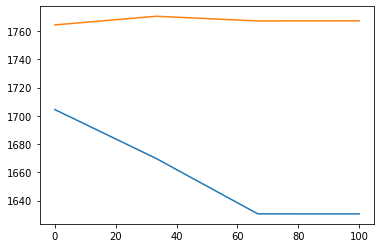

In [7]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 100, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.show()

... storing 'cell_type' as categorical


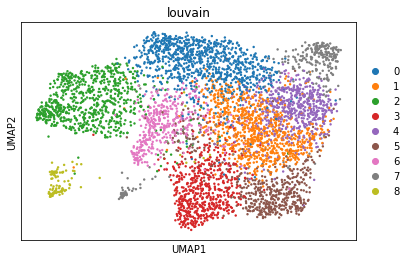

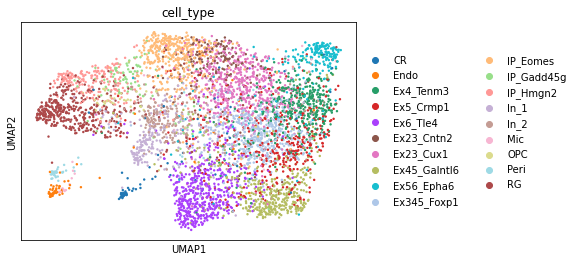

In [8]:
# 输出模型结果
# posterior

full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()
# visulization
prior_adata = anndata.AnnData(X=latent)
prior_adata.obsm["X_multi_vi"] = latent
cell_embeddings = pd.read_csv(input_path+'snare_p0_wnn_output.txt', sep="\t",index_col=0).iloc[:,[5,12]]
prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"IdentChar"].to_list()
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

sc.pl.umap(prior_adata, color=['cell_type'])
plt.show()

In [ ]:

df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=dataset.barcodes)
df.insert(0,"louvain",prior_adata.obs['louvain'].values)
df.to_csv(os.path.join(output_path,"multivae_umap_no_pretrain.csv"))

df = pd.DataFrame(data=imputed_values[1].T, columns=dataset.barcodes, index=dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation_no_pretrain.csv"))


In [36]:
# over 95 quantile
def binarization(imputed, raw):
    return (imputed.T > np.quantile(imputed,q=0.95,axis=1)).astype(np.int8)

atac_binary=binarization(imputed_values[1],dataset.atac_expression)
df = pd.DataFrame(data=atac_binary, columns=dataset.barcodes, index=dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation_no_pretrain_binary.csv"))